In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from functools import partial
import time
from tqdm import tqdm   


import argparse



import sys
sys.path.append('dinov2')

# Load model class (assuming it’s saved in another file, or copy its code here)
# Assuming the Dino model class is defined in the original training script
from dinov2.eval.linear import create_linear_input
from dinov2.eval.linear import LinearClassifier
from dinov2.eval.utils import ModelWithIntermediateLayers

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
d:\CodesNStuffs\DinoV2_Classification\dinov2\dinov2\layers\swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
d:\CodesNStuffs\DinoV2_Classification\dinov2\dinov2\layers\attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
d:\CodesNStuffs\DinoV2_Classification\dinov2\dinov2\layers\block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [2]:
# Set up arguments
class Args:
    arch = 'dinov2_vitb14'
    batch_size = 128
    log_dir = './'
    data_dir = 'cat_dog_data/organized'  # Path to dataset

args = Args()

class Dino(nn.Module):
    def __init__(self, type):
        super().__init__()
        model = torch.hub.load(
            "facebookresearch/dinov2", type, pretrained=True
        ).to(device)
        autocast_ctx = partial(
            torch.cuda.amp.autocast, enabled=True, dtype=torch.float16
        )
        self.feature_model = ModelWithIntermediateLayers(
            model, n_last_blocks=1, autocast_ctx=autocast_ctx
        ).to(device)

        with torch.no_grad():
            sample_input = torch.randn(1, 3, 224, 224).to(device)
            sample_output = self.feature_model(sample_input)

        out_dim = create_linear_input(
            sample_output, use_n_blocks=1, use_avgpool=True
        ).shape[1]
        self.classifier = LinearClassifier(
            out_dim, use_n_blocks=1, use_avgpool=True, num_classes=100
        ).to(device)

    def forward(self, x):
        x = self.feature_model(x)
        x = self.classifier(x)
        return x


In [3]:
# Define test transforms
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load test dataset
test_dataset = datasets.ImageFolder(os.path.join(args.data_dir, 'test'), transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)


In [4]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned model
model = Dino(args.arch)
model.load_state_dict(torch.load(os.path.join(args.log_dir, 'best_model.pth')))
model.to(device)
model.eval()  # Set to evaluation mode


Using cache found in C:\Users\user/.cache\torch\hub\facebookresearch_dinov2_main


Dino(
  (feature_model): ModelWithIntermediateLayers(
    (feature_model): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-11): 12 x NestedTensorBlock(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=3072,

  0%|          | 0/1 [00:00<?, ?it/s]

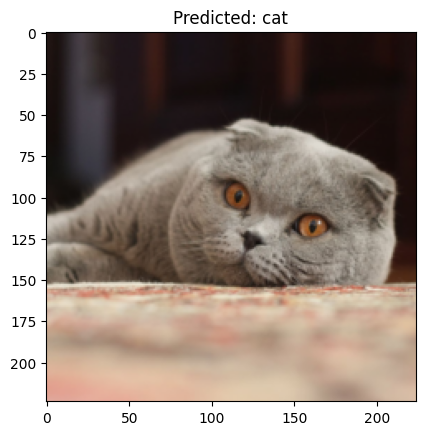

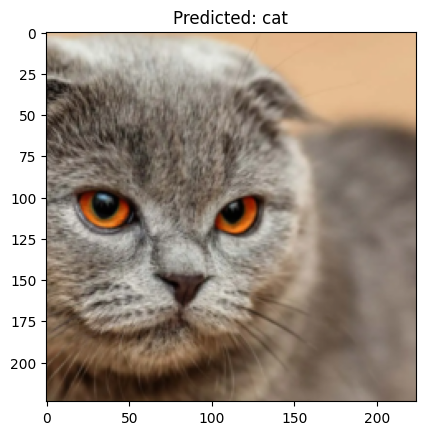

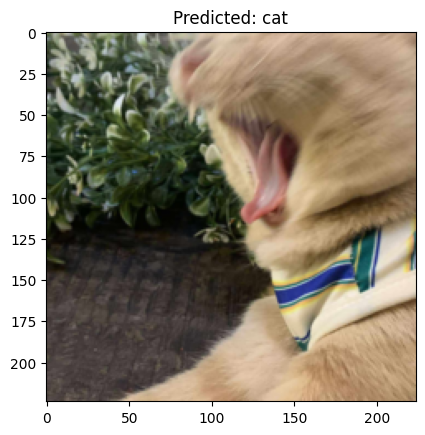

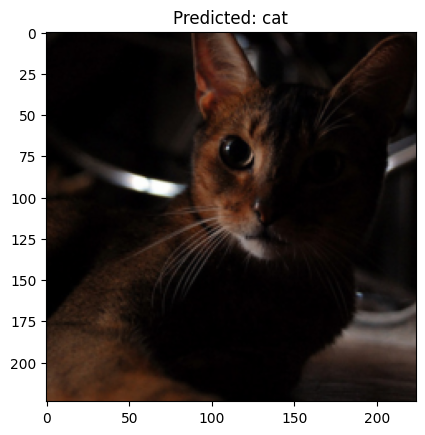

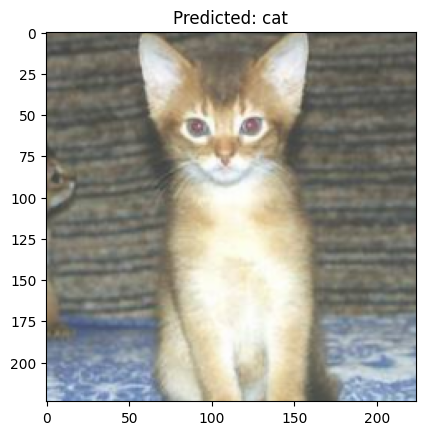

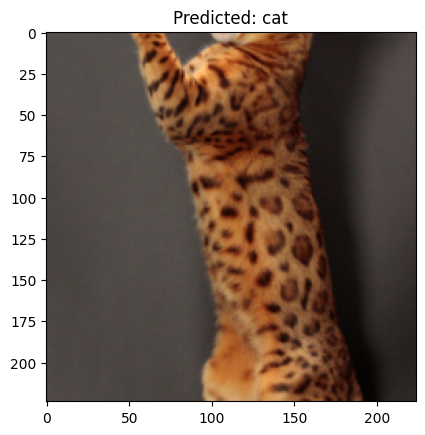

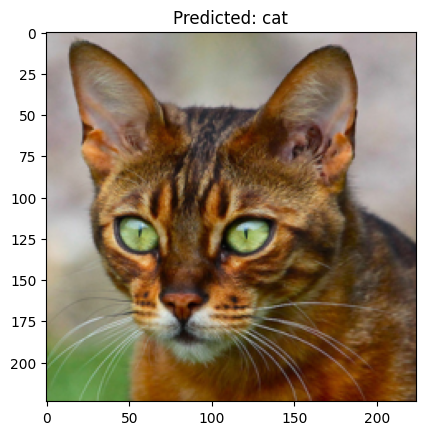

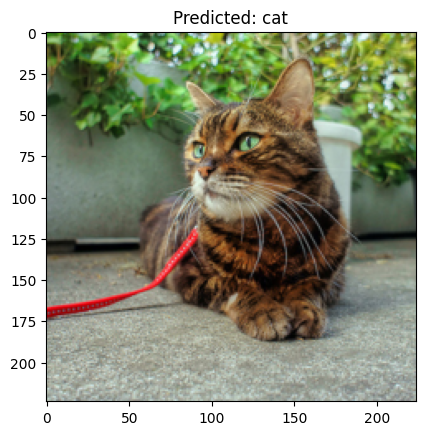

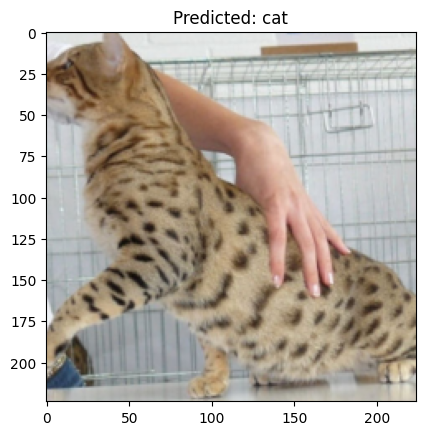

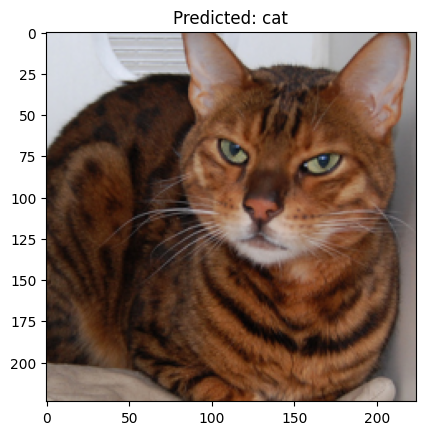

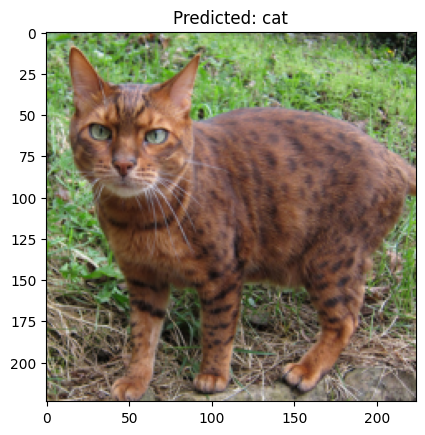

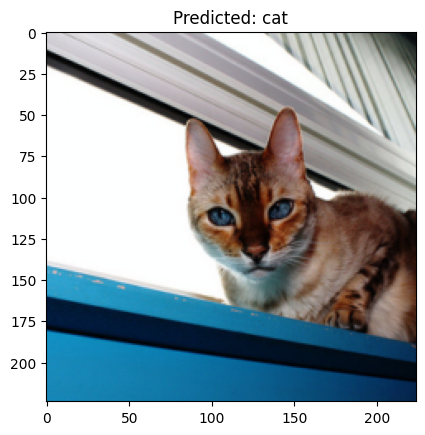

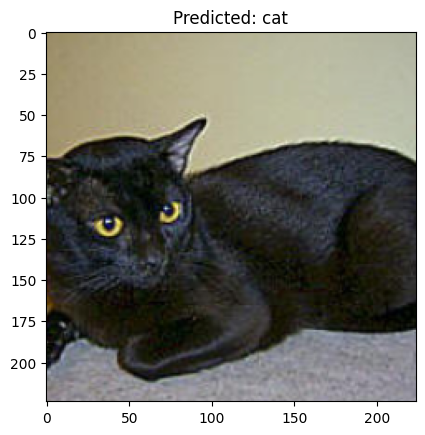

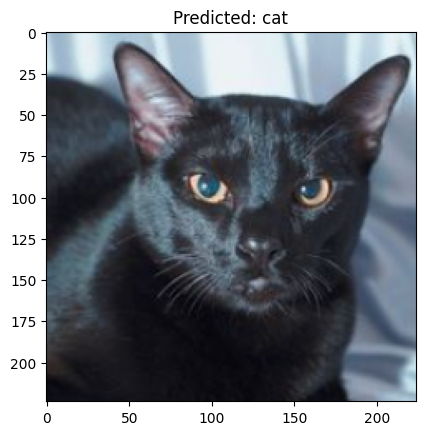

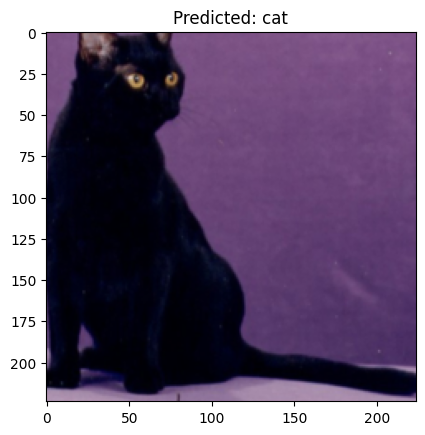

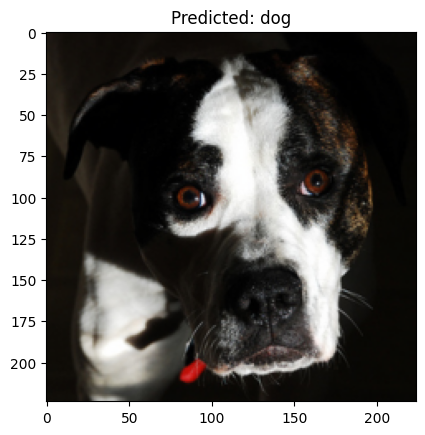

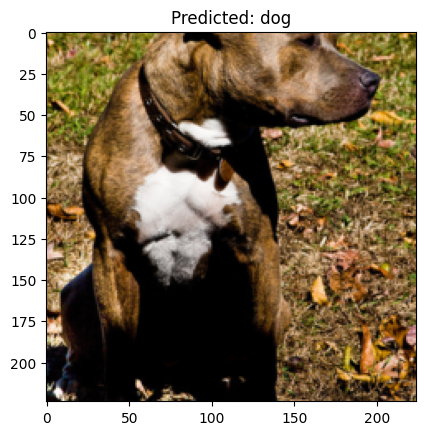

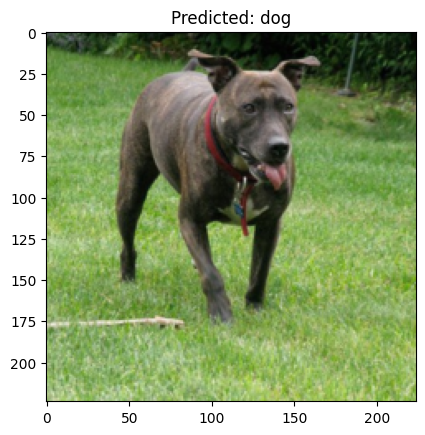

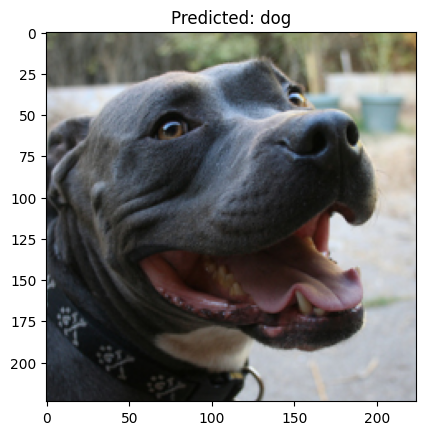

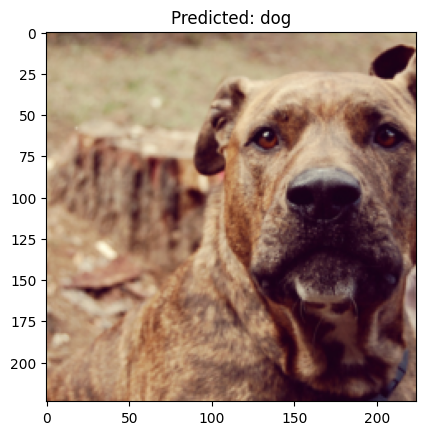

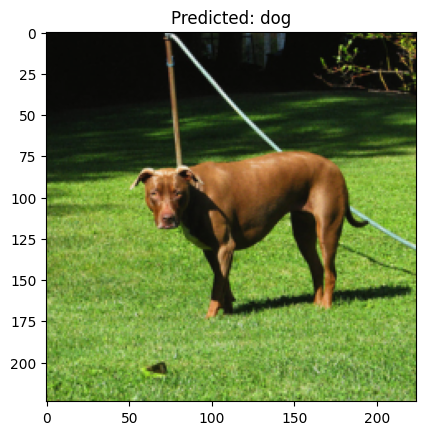

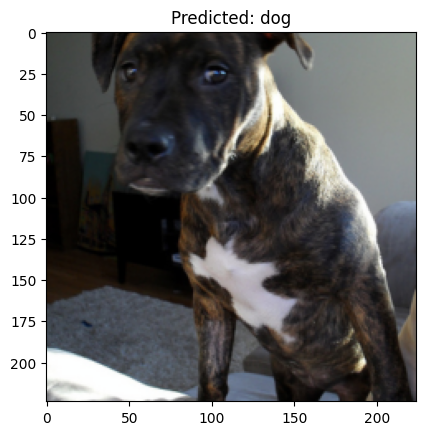

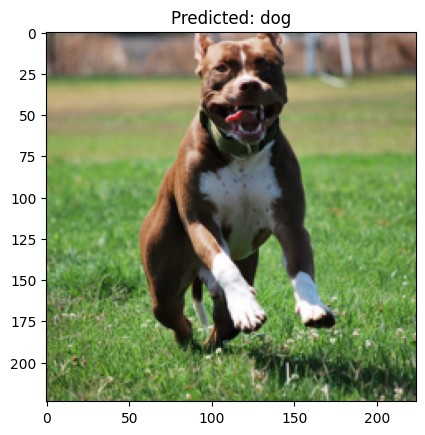

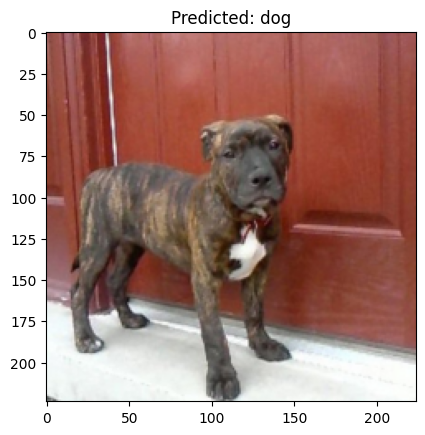

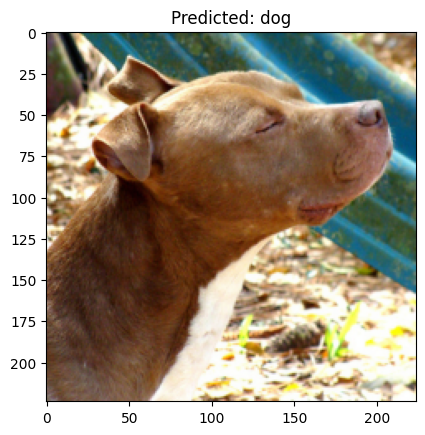

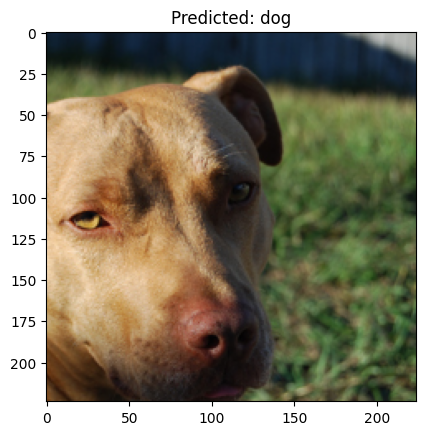

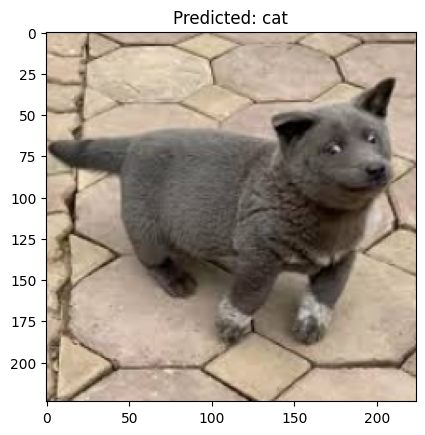

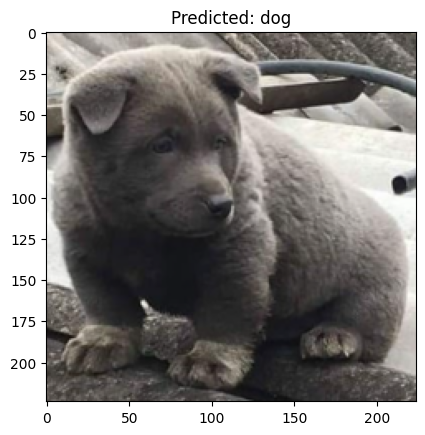

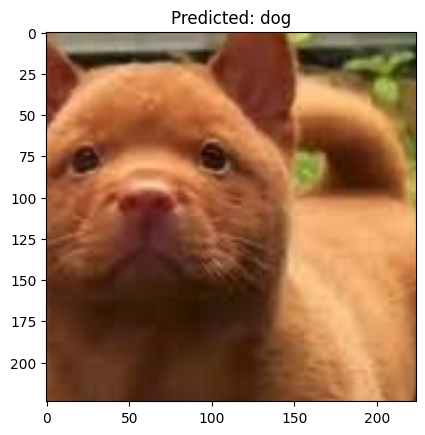

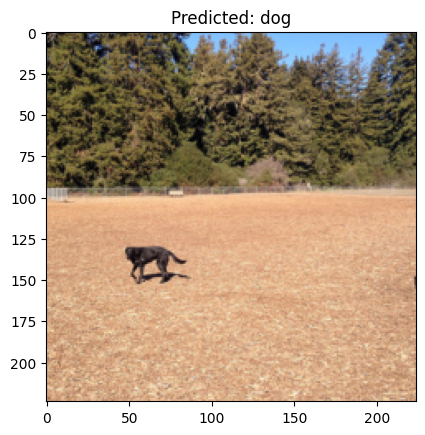

100%|██████████| 1/1 [00:11<00:00, 11.98s/it]

Test Accuracy: 0.9667


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to display images in a grid
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause to update plots

# Variable to keep track of correct predictions
running_corrects = 0

# Run model in evaluation mode and no gradient
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Get features and make predictions
        features = model.feature_model(inputs)
        outputs = model.classifier(features)
        _, preds = torch.max(outputs, 1)
        
        # Update running corrects
        running_corrects += torch.sum(preds == labels.data)

        # Move inputs and predictions to CPU for displaying images
        inputs = inputs.cpu()
        preds = preds.cpu()
        
        # Display images and predictions
        for i in range(inputs.size(0)):
            imshow(inputs[i], title=f'Predicted: {test_dataset.classes[preds[i]]}')
            plt.show()  # Display each image

# Calculate and print accuracy
test_acc = running_corrects.double() / len(test_dataset)
print('Test Accuracy: {:.4f}'.format(test_acc))
